# Mostly Harmless Convolutions

*Kaiyan Zhang, prAxIs UBC Team*  
2025-07-24

**Before you begin: Install the dependencies that you don’t have by
running the code cell below.**

In [1]:
# !pip install opencv-python
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install scikit-learn

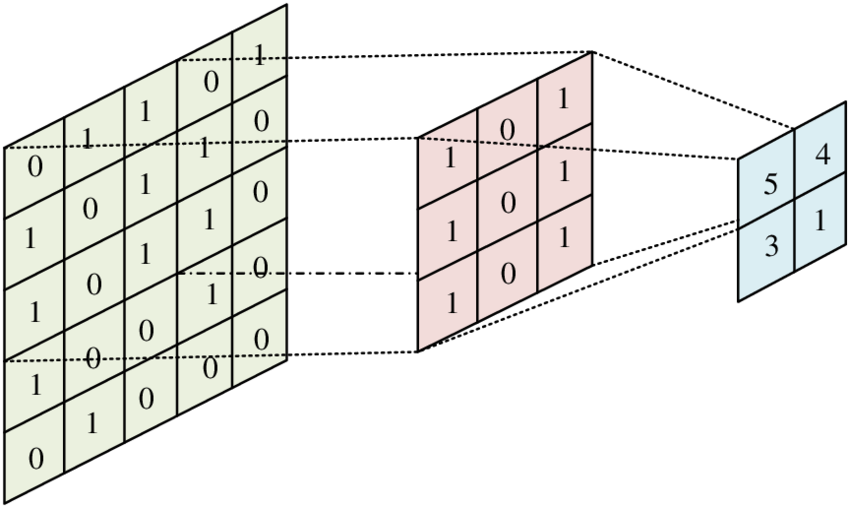

#### Why Convolutions?

Mathematically speaking, **Convolution** is an operation that combines
two functions to produce a third function, which has a variety of
applications in signal processing, image analysis and more. While this
may sound complex, we can minimize the math behind it and explain it in
a less harmful and vivid way.

Let’s begin by imagining a simple scenario: you took a picture of a cute
dog, and you want to apply a filter to it so that it looks more vibrant
and colorful. Now that you input the image into a computer, how does a
computer “see” it? The computer would see the image as a grid of
numbers, where the combination of 3 numbers (R, G, B) in a grid
represents the color of a pixel, and with all the colored pixels
combined, it forms the image. Given the numeric nature of a computer
image, we say that the image is digitalized.

Here, let’s read in the image into Python using `OpenCV` and display it
using `matplotlib`:

In [2]:
# Load necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Read the image in BGR format
doge_bgr = cv2.imread('data/Original_Doge_meme.jpg')

doge_rgb = cv2.cvtColor(doge_bgr, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(doge_rgb)
plt.axis('off')  
plt.title('Input Image')
plt.show()

The image doesn’t look like numbers, does it? In fact, if we zoom in
close enough, we can clearly see that the image is made up of pixels.
But we still don’t see the numbers, this is because the numerical
information is decoded by the computer and displayed as a colored pixel.
However, we can easily convert the image into a numerical
representation.

For demonstration purpose, I rescale the image to a 10 $\times$ 10 grid,
where within each cell, the tuple represents the RGB values (0-255) of
each pixel. Note that compressing images to a smaller size is always
easier comparing to enhancing images to a larger size, as compression
can be done by going through the image pixel by pixel and averaging the
color values in each cell, while enhancement usually requires more
complex operations. This gives us a hint on why convolution is
important.

In [3]:
img_rgb = cv2.resize(doge_rgb, (10, 10), interpolation=cv2.INTER_NEAREST)

# Plot the RGB matrix
fig, ax = plt.subplots(figsize=(6, 6))


h, w = img_rgb.shape[:2]
ax.imshow(img_rgb, extent=[0, w, h, 0]) 

# Set ticks to show grid at pixel boundaries
ax.set_xticks(np.arange(0, w + 1, 1))
ax.set_yticks(np.arange(0, h + 1, 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(color='black', linewidth=1)

for i in range(h):
    for j in range(w):
        r, g, b = img_rgb[i, j]
        brightness = int(r) + int(g) + int(b)
        color = 'white' if brightness < 380 else 'black'
        ax.text(j + 0.5, i + 0.5, f'({r},{g},{b})',
                ha="center", va="center", fontsize=6, color=color)
        
        
# Display the Grid
ax.set_title("RGB Value Grid of Doge Image Resized to 10x10")
plt.tight_layout()
plt.show()

The image has become a little abstract. Can you still identify the
original image out of it?

While the resized image looked significantly different, it still
contains the necessary information, and same ideas also transits to
larger images. That is, all images can be represented as a grid of
numbers, where the 3 numbers in each cell corresponds to the color of a
pixel. Computers can’t see colors like we do, the way they see colors is
as if they were mixing colors using a palette that only has red, green
and blue (**RGB**), where each color has an “amount” of intensity
between 0 and 255. With the 3 values for red, green and blue, computers
can create any color we see in the world.

Back to the dog picture, it is easy to see that resizing the image to a
smaller grid loses a lot of details, especially the rich color that
makes the image vibrant. If we want to keep the complete color
information alternatively, we can plot out the distribution of the RGB
values and frequencies in the image using a histogram. While this gives
us a good idea of the color distribution, it does not tell us much about
the spatial relationships between the pixels.

In [4]:
# Compute and plot the color histogram
colors = ('r', 'g', 'b')
plt.figure(figsize=(6, 4))

for i, col in enumerate(colors):
    hist = cv2.calcHist(
        images=[doge_bgr],       # source image (still in BGR)
        channels=[i],           # which channel: 0=B, 1=G, 2=R
        mask=None,              
        histSize=[256],         
        ranges=[0, 256]         
    )
    plt.plot(hist, color=col)
    plt.xlim([0, 256])
    
# Display the histogram
plt.title('RGB Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Can you still identify the original image out of it?

The example above shows us what images are like in the eyes of a
computer. Computers do not understand images in the same way that humans
do, they can only see them as a collection of numbers. It thus make
sense that we need to apply some math to these numbers to either
**change the image** or **extract some useful information** from it, and
that’s where convolution comes in.

#### How Does Convolution Work?

Before we dive into the application of it, let’s first understand how
convolution operate on an image in a more intuitive way:

Imagine you are copying a painting, you first made a draft of the same
size against the original painting and now you want to color it. Other
than making your painting a 100% identical copy, you want to add some
personal touch to it, so you decide to use a brush with a specific
pattern to color the draft. Wherever you apply the brush, it will color
the region it touches with a brighter color than the original painting,
and your color your draft from left to right, top to bottom, until the
whole draft is colored with the brush. You end up with a new painting
that is similar to the original one, but with a different style.

Here, the brush you used is called a **kernel** in the context of
convolution, and the process of applying the brush is what we call
**convolution operation**. We would define the kernel as a small matrix
of numbers that represents the pattern of the brush, and the convolution
operation as the process of transforming the original image by applying
the kernel to it.

Here is a gif illustrating how our filter (the kernel) will work on the
image mathematically. You can see it as the small brush that slides over
the image, operating on a small region of the image at a time, and
eventually producing a new image that was completely transformed by the
filter.

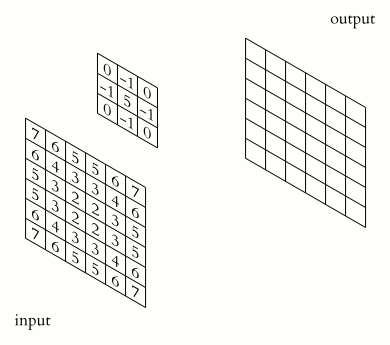

Now, let’s return to the example of the cute dog picture. What we are
going to apply is a brush called **sharpening filter**, it is a 3
$\times$ 3 matrix that looks like this:

$$\text{Sharpening Filter} = \begin{bmatrix}
 0 &-1 & 0 \\
-1 & 5 & -1 \\
 0 & -1 & 0 
\end{bmatrix}$$ **Don’t panic** as we are not going to do any math here,
we will just let computer do the math for us. The only thing you need to
know is that this kernel will enhance the edges of the image, making it
look sharper and more defined. In fact, if you take a closer look at the
kernel, you will see that it has a positive value in the center and
negative values around it, and it has 0 values on the corners. This
exactly looks like a brush that enhances the center of a region while
reducing the intensity of the surrounding pixels, which is exactly what
we want to achieve with the filter.

In [5]:
# Define the sharpening filter
kernel = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
filtered = cv2.filter2D(doge_rgb, ddepth=-1, kernel=kernel)

filtered = np.clip(filtered, 0, 255).astype(np.uint8)

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Input
ax1.imshow(doge_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(filtered)
ax2.set_title("Filtered Image (Sharper & More Vibrant)")
ax2.axis("off")

plt.tight_layout()
plt.show()

The difference is quite obvious now. You can clearly see that the
sharpened image (R) has more contrast and the edges are more defined,
making it look more vibrant and colorful. This is the power of
convolution, it allows us to apply filters to images and transform them
in a way that is not possible with simple pixel manipulation. Similarly,
we can blur an image quite easily, for which the “brush” we are going to
use looks like this

$$\text{Box Blur Filter} = \begin{bmatrix}
\frac{1}{9} &\frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} 
\end{bmatrix}
$$

Let’s see what it will make.

In [6]:
# Define the box blur filter
kernel = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
filtered = cv2.filter2D(doge_rgb, ddepth=-1, kernel=kernel)

filtered = np.clip(filtered, 0, 255).astype(np.uint8)

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Input
ax1.imshow(doge_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(filtered)
ax2.set_title("Filtered Image (Blurred)")
ax2.axis("off")

plt.tight_layout()
plt.show()

It worked as we expected, now the dog image becomes more blurry.

However, convolution on image is not limited to filtering, it can also
be used to **extract features** from the image. For example, we can use
a kernel to detect edges, lines and texts in images, we can even use
specific kernels to detect specific shapes or patterns in images, such
as a kernel that detects anything that looks like a dog. As you can
imagine, this is a very powerful tool in many applications, in fact, you
most likely have already used it in your daily life. For example, when
you use a photo editing app to apply a filter to your picture, the app
is using convolution. When you use a search engine to search do image
searches, the search engine is using convolution to extract features
from the images and match them with your search query. Let’s say, the
thing you are trying to find is eyes, the gif below shows how a
convolution kernel detects “eyes” in an image:

<img src="media/eye_detection_kernel.gif" alt="A visualization of convolution operation that detects a feature" width="600"/>

This is a very simple example, and it is implemented exactly the same
way as we did with the sharpening filter. The only difference is that to
extract a specific features, we need to use a “brush” designed to detect
that feature, which usually requires some knowledge of the feature we
want to extract. For example, if we want to detect eyes in the painting,
we would need our “brush” to understand what eyes look like and what
typical colors they have. This could be way too complicated for a single
“brush”, so we often use multiple brushes to detect different features
when it comes to the task of feature extraction.

To demonstrate how convolution extracts a specific feature from an
image, let’s take a look at a different “art tool”. Let’s say this time
you don’t want to color the painting differently, but rather you want to
sketch a line art based on the original painting. You would use a
fineliner pen that detects the edges of a painting and draw a line along
them. In the eyes of a computer, these are the tools it is going to use:

$$\text{Horizontal Sobel} = \begin{bmatrix}
 1 & 0 & -1 \\
 2 & 0 & -2 \\
 1 & 0 & -1
\end{bmatrix} 
\text{, }
\text{Vertical Sobel} = \begin{bmatrix}
 1 & 2 & 1 \\
 0 & 0 & 0 \\
 -1 & -2 & -1
\end{bmatrix} 
$$

Still, **don’t panic**, we won’t do any math in this notebook. All you
need to know is these two kernels together are called **Sobel filter**,
and what they do is highlighting the edges in the image, making them
more visible. If you take a closer look at the kernels, you will see
that the first one has positive values on the left and negative values
on the right, while the second one has positive values on the top and
negative values on the bottom. This pattern intuitively tells us that
the first “pen” will scan through the image horizontally and extract the
horizontal edges, while the second “pen” will scan through the image
vertically and extract the vertical edges.

Let’s now look at a different example and see what happens when we apply
the Sobel filter.

In [7]:
# Generate a greyscale version of the image
hill_bgr = cv2.imread('data/xiangbishan.jpg')

hill_rgb = cv2.cvtColor(hill_bgr, cv2.COLOR_BGR2RGB)

hill_gray = cv2.cvtColor(hill_bgr, cv2.COLOR_BGR2GRAY)

# Define the Sobel filter kernel
sb_kernel_h = np.array([
    [ 1, 0, -1],
    [ 2, 0, -2],
    [ 1, 0, -1]
], dtype=np.float32)

sb_kernel_v = np.array([
    [ 1, 2, 1],
    [ 0, 0, 0],
    [-1, -2, -1]], dtype=np.float32)

# Apply the kernel to the color image using filter2D.
horiz = cv2.filter2D(hill_gray, -1, sb_kernel_h)

vert = cv2.filter2D(hill_gray, -1, sb_kernel_v)

combined = cv2.convertScaleAbs(np.sqrt(vert.astype(np.float32)**2 + horiz.astype(np.float32)**2))

# Display the original and filtered images side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

# Input
ax1.imshow(hill_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Output
ax2.imshow(combined, cmap = 'gray')
ax2.set_title("Filtered Image (Edges Highlighted)")
ax2.axis("off")

plt.tight_layout()
plt.show()

As we can see in the example above, the Sobel filter detects the edges
in the image and highlights them like a fineliner pen. This is a very
useful technique in image processing, as it allows us to extract
features from the image that can be used for further analysis or
classification. Let’s do more explorations with the example above:

In [8]:
# Compute the magnitude and orientation of the gradient.
# To put it simpler, they represents the length and direction of the edges at each pixel.
# For those who are familiar with pythagorean theorem, the magnitude is exactly the length of the"long edge" calculated with pythagorean theorem.
magnitude = np.sqrt(vert.astype(np.float32)**2 + horiz.astype(np.float32)**2)
orientation = np.arctan2(vert.astype(np.float32), horiz.astype(np.float32))

# Generate an edge binary map
mag_norm = cv2.normalize(magnitude, None, 0,255, cv2.NORM_MINMAX).astype(np.uint8)
_, edge_binary = cv2.threshold(mag_norm, 50, 255, cv2.THRESH_BINARY)

# Create the Contour plot
contours, _ = cv2.findContours(edge_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = hill_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (255,0,0), 1)

# Create an edge density heatmap
block = 32
h, w = edge_binary.shape
int_img = cv2.integral(edge_binary)

heatmap = np.zeros_like(edge_binary, dtype=np.float32)

for y in range(0, h - block + 1):
    for x in range(0, w - block + 1):
        y1, x1 = y,       x
        y2, x2 = y + block, x + block
        total = (int_img[y2, x2]
               - int_img[y1, x2]
               - int_img[y2, x1]
               + int_img[y1, x1])
        # center the block’s density back into the heatmap
        heatmap[y + block//2, x + block//2] = total
        
heatmap = cv2.normalize(heatmap, None, 0,255, cv2.NORM_MINMAX).astype(np.uint8)

# Plot out the visualizations
fig, axs = plt.subplots(2, 2, figsize=(8, 5))
ax1, ax2, ax3, ax4 = axs.flatten()

# Original Image
ax1.imshow(hill_rgb)
ax1.set_title("Input Image")
ax1.axis("off")

# Contours on Original Image
ax2.imshow(contour_img)
ax2.set_title("Contours on Original Image")
ax2.axis("off")

# Edge Density Heatmap
ax3.imshow(heatmap, cmap="hot")
ax3.set_title("Edge Density Heatmap")
ax3.axis("off")

# Edge Orientation Histogram
angles_deg = np.degrees(orientation[magnitude > 50].flatten())

ax4.hist(angles_deg, bins=36, range=(0, 90), color='purple')
ax4.set_title("Edge Orientation Histogram")
ax4.set_xlabel("Angle (degrees)")
ax4.set_ylabel("Frequency")


plt.tight_layout()
plt.show()

Here, we have generated three other visualizations based on the
extracted edge data.

-   The first visualization is a Contour Map on the original image. It
    circles contours from the image that are distinguishable from
    others. In many cases, this implies the circled regions have
    different visual patterns or belong to different objects, which is
    very useful in tasks such as image recognition.
-   The second visualization is the Edge Density Heatmap that assigns
    corresponding heat values to regions on the image based on the
    density distribution of the edges. The lighter the color, the higher
    the edge density of the region. This helps us to understand which
    area of the image carries the most information that may be of
    interest to us.
-   The third visualization is a histogram showing the distribution of
    edge orientations. edge orientation is the direction of the edge in
    the graph, expressed as the angle between the edge and the x-axis
    (horizontal line). Understanding the distribution of edge
    orientation can help us better recognize the graphical features of
    objects in an image for tasks such as classification. For example,
    based on this image featuring a hill and a water surface, we now
    know that the edges of these two objects typically have either a
    horizontal or vertical orientation.

The examples above demonstrated the power of convolution in both image
processing and image analysis, and more importantly, convolution is very
efficient, as it is easy for computers to understand and process, and
can be applied to images of any size without losing any information.
This is why convolution has become a fundamental operation in computer
vision and image processing.

But as you have probably aware, implementing convolution from scratch
can be quite tedious, especially when we need to perform more specific
tasks such as detecting texts or some specific shapes. To protect the
brains of computer scientists, a more advanced, adaptable and efficient
way of applying convolution has been developed, which is called
**Convolutional Neural Networks (CNNs)**, and we will discuss it in the
next notebook, hopefully in a way that also protects your brain.

#### Key takeaways from this Notebook:

1.  Computers see images as grids of numbers, where each grid cell
    contains the RGB values of a pixel. With the spatial relationships
    and the color information, computers can understand images without
    losing information.
2.  **Convolution** is an operation that applies a filter (kernel) to an
    image, transforming it in a way that enhances certain features or
    extracts useful information. It is like using a brush to color a
    painting or a pen to sketch a line art.
3.  The kernel that sharpens an image is called a **sharpening filter**,
    which enhances the edges of the image and makes it look more
    vibrant. The kernel that detects edges is called **Sobel filter**,
    which highlights the edges in the image and makes them more visible.
4.  Convolution is a powerful tool that can be used in many
    applications, such as photo editing, image search and feature
    extraction. It is efficient and can be applied to images of any size
    without losing information.

### Additional Resources

-   [3Blue1Brown: But what is a
    convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA) A
    mathematical introductory video to convolution with rich visualized
    explanations. This may be particularly helpful to those who want to
    dig deeper in the mathematical perspective and were not panic when
    they saw the matrices show up in this notebook (I’m really sorry if
    that made you nervous).

### References

-   Wikipedia. Convolution。 Retrieved June 18, 2025, from
    <https://en.wikipedia.org/wiki/Convolution>
-   Neuromatch Academy. Computational Neuroscience. Tutorial 2:
    Convolutional Neural Networks. Retrieved June 18, 2025, from
    <https://compneuro.neuromatch.io/tutorials/intro.html>
-   GeeksForGeeks. Types of Convolution Kernels
    <https://www.geeksforgeeks.org/deep-learning/types-of-convolution-kernels>
-   OpenCV. Image Processing in OpenCV
    <https://docs.opencv.org/4.x/d2/d96/tutorial_py_table_of_contents_imgproc.html>